# Forward Collars
Price forward collars using different models. Forward collars are insightful because

- they are sensitive to the forward skew of the implied volatility surface, and therefore highlight the forward vol dynamics of each model.
- a cliquet can be thought of as a series of forward collars.

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow as pa
from matplotlib import pyplot as plt
from qablet.black_scholes.mc import LVMCModel
from qablet.heston.mc import HestonMCModel
from qablet_contracts.timetable import TS_EVENT_SCHEMA

from data.spx_2005_09_15 import (
    heston_data,
    localvol_data,
    rbergomi_data,
    basic_info,
)
from src.model.rbergomi import rBergomiMCModel

### Forward Collars
Forward collars are not in the qablet_contracts package. We will write a method to create forward collars here, using the [qablet specifications](https://qablet.github.io/qablet-contracts/specifications/timetable/). Forward collar has two events

- set the strike, at a future strike time, using a given strike_rate
- pay at maturity, based on above strike, and a collar width.

In [2]:
# Create a Collar
def fwd_collar_timetable(ticker, strike_rate, width, strike_time, maturity):
    events = [
        {
            "track": None,
            "time": strike_time,
            "op": None,
            "quantity": 0,
            "unit": "FIX",  # set strike
        },
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",  # pay collar
        },
    ]

    # Define the strike phrase, which is the spot times strike rate.
    def strike_fn(inputs):
        [s] = inputs
        return [s * strike_rate]

    # Define collar phrase, which is spot - K, capped and floored.
    def collar_pay_fn(inputs):
        [s, k] = inputs

        ret = np.maximum(-width, s - k)
        ret = np.minimum(width, ret)

        return [ret]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker, "K"],
                "fn": collar_pay_fn,
            },
            "FIX": {
                "type": "snapper",
                "inp": [ticker],
                "fn": strike_fn,
                "out": ["K"],
            },
        },
    }


# Try an example:
timetable = fwd_collar_timetable(
    "SPX", 1.0, 10, datetime(2013, 10, 31), datetime(2013, 12, 31)
)
print(timetable["events"].to_pandas())

  track                      time   op  quantity    unit
0   NaN 2013-10-31 00:00:00+00:00  NaN       0.0     FIX
1       2013-12-31 00:00:00+00:00    +       1.0  COLLAR


The Collar Payoff is like this.

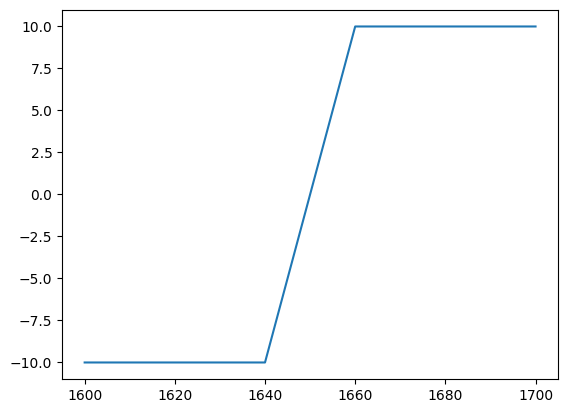

In [3]:
K = 1650
s_vec = np.linspace(K - 50, K + 50, 11)
fn = timetable["expressions"]["COLLAR"]["fn"]
pay_vec = fn([s_vec, K])[0]
plt.plot(s_vec, pay_vec)

Create a series of forward collars starting at different expiration dates, setting strike one month prior.

In [4]:
info = basic_info()
prc_dt = info["prc_dt"]
exp_dt = prc_dt + pd.DateOffset(years=1)

dates = pd.bdate_range(prc_dt, exp_dt, freq="1BME")
fix_dates = dates[:-1]
exp_dates = dates[1:]

timetables = []
for fix_dt, exp_dt in zip(fix_dates, exp_dates):
    timetables.append(
        fwd_collar_timetable(
            "SPX",
            strike_rate=1.0,
            width=10,
            strike_time=fix_dt,
            maturity=exp_dt,
        )
    )

### Compare Models
Compare different models, starting with Local Volatility Model.

In [5]:
model = LVMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, localvol_data())
    prices.append(price)

df = pd.DataFrame(
    {"fix date": fix_dates, "exp date": exp_dates, "LocalVol": prices}
)
df

,fix date,exp date,LocalVol
0,2005-09-30,2005-10-31,0.755057
1,2005-10-31,2005-11-30,0.454365
2,2005-11-30,2005-12-30,0.296453
3,2005-12-30,2006-01-31,0.232659
4,2006-01-31,2006-02-28,0.160179
5,2006-02-28,2006-03-31,0.045462
6,2006-03-31,2006-04-28,0.052400
7,2006-04-28,2006-05-31,0.012612
8,2006-05-31,2006-06-30,0.046476
9,2006-06-30,2006-07-31,0.003573


Heston Model

In [6]:
model = HestonMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, heston_data())
    prices.append(price)
df["Heston"] = prices
df

,fix date,exp date,LocalVol,Heston
0,2005-09-30,2005-10-31,0.755057,0.627108
1,2005-10-31,2005-11-30,0.454365,0.573407
2,2005-11-30,2005-12-30,0.296453,0.578559
3,2005-12-30,2006-01-31,0.232659,0.555577
4,2006-01-31,2006-02-28,0.160179,0.512987
5,2006-02-28,2006-03-31,0.045462,0.511881
6,2006-03-31,2006-04-28,0.052400,0.488058
7,2006-04-28,2006-05-31,0.012612,0.498360
8,2006-05-31,2006-06-30,0.046476,0.472085
9,2006-06-30,2006-07-31,0.003573,0.479045


Bergomi Model

In [7]:
model = rBergomiMCModel()
dataset = rbergomi_data()
dataset["MC"]["PATHS"] = 20_000  # very slow with 100_000, 1/250
dataset["MC"]["TIMESTEP"] = 1 / 100

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["rBergomi"] = prices
df

,fix date,exp date,LocalVol,Heston,rBergomi
0,2005-09-30,2005-10-31,0.755057,0.627108,1.162355
1,2005-10-31,2005-11-30,0.454365,0.573407,0.992148
2,2005-11-30,2005-12-30,0.296453,0.578559,0.999626
3,2005-12-30,2006-01-31,0.232659,0.555577,0.920215
4,2006-01-31,2006-02-28,0.160179,0.512987,0.790283
5,2006-02-28,2006-03-31,0.045462,0.511881,0.897937
6,2006-03-31,2006-04-28,0.052400,0.488058,0.851257
7,2006-04-28,2006-05-31,0.012612,0.498360,0.842179
8,2006-05-31,2006-06-30,0.046476,0.472085,0.816673
9,2006-06-30,2006-07-31,0.003573,0.479045,0.769578


## Plot

<Axes: xlabel='exp date'>

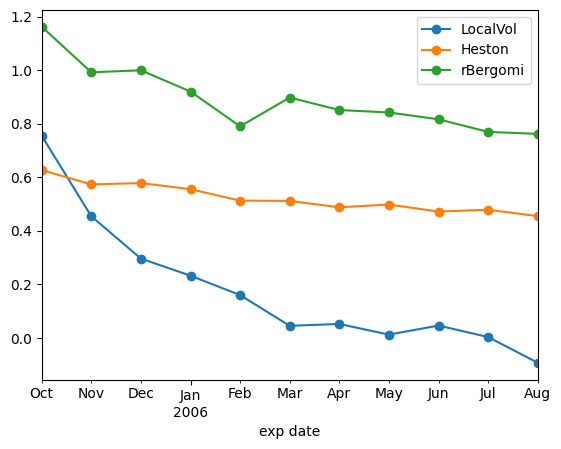

In [8]:
df.columns
df.plot(x="exp date", y=["LocalVol", "Heston", "rBergomi"], marker="o")